## Imports

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, ConcatDataset, WeightedRandomSampler
from torchvision import datasets, transforms as T
import wandb
import json
import numpy as np
import random
import os
from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt
print(f'PyTorch CUDA is available? {torch.cuda.is_available()}')

#For saving the result of the training in a dirve folder 
#from google.colab import drive
#drive.mount('/content/drive')

PyTorch CUDA is available? True


## Reproducibility

In [3]:
def fix_random(seed: int) -> None:
    """Fix all the possible sources of randomness.

    Args:
        seed: the seed to use.
    """
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

fix_random(42)

In [4]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Device: {device}")

Device: cuda


### Initial set up of configuration parameters

In [5]:
##Configurations

cfg_data = {
    'std_size' : 224, # 260
    'rand_crop_size' : 150,
    'n_classes' : 43,
}

cfg_hyp = {
    'lr' : 3e-4,
    'wd' : 3e-5, # 1e-5
    'epochs' : 30, # 50
    'batch_size' : 64, # 32
    'scheduler' : True,
    'device' : device,
    'stopping_patience' : 10,
    'stopping_value' : 0.9
}


## Download and exploration of the dataset 

In [6]:
from pathlib import Path
from PIL import Image
from torch import Tensor
from typing import List, Tuple

In [7]:
class GroceryStoreDataset(Dataset):

    def __init__(self, split: str, transform=None) -> None:
        super().__init__()

        self.root = Path("GroceryStoreDataset/dataset")
        self.split = split
        self.paths, self.labels = self.read_file()

        self.transform = transform

    def __len__(self) -> int:
        return len(self.labels)

    def __getitem__(self, idx) -> Tuple[Tensor, int]:
        img = Image.open(self.root / self.paths[idx])
        label = self.labels[idx]

        if self.transform:
            img = self.transform(img)

        return img, label

    def read_file(self) -> Tuple[List[str], List[int]]:
        paths = []
        labels = []

        with open(self.root / f"{self.split}.txt") as f:
            for line in f:
                # path, fine-grained class, coarse-grained class
                path, _, label = line.replace("\n", "").split(", ")
                paths.append(path), labels.append(int(label))

        return paths, labels

    def get_num_classes(self) -> int:
        return max(self.labels) + 1
    
    #My adding for balance the dataset
    def get_class_weights(self) -> torch.Tensor:
        class_counts = np.bincount(self.labels)
        class_weights = 1. / torch.tensor(class_counts, dtype=torch.float)
        return class_weights

    def get_sampler(self) -> WeightedRandomSampler:
        class_weights = self.get_class_weights()
        sample_weights = [class_weights[label] for label in self.labels]
        return WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

In [8]:
## Rimettere a 260x260 o a 224x224 (per resnet)

n_classes = cfg_data['n_classes']

tsfms_std = T.Compose([
    T.Resize(size=(cfg_data['std_size'], cfg_data['std_size'])),
    T.ToTensor(),
    # T.Lambda(lambda x: x.flatten()),
])

#DATA AUGMENTATION
#tsfms_increasing = T.Compose([
#    T.RandomRotation(15),
#    T.RandomResizedCrop(32, scale=(0.9, 1.1)),
#    T.RandomHorizontalFlip(),
#    T.RandomResizedCrop(size=(cfg_data['rand_crop_size'], cfg_data['rand_crop_size']), scale=(0.7, 0.9)),
#    T.ToTensor(),
#    T.Resize(size=(cfg_data['std_size'], cfg_data['std_size'])),
#    # T.Lambda(lambda x: x.flatten()),
#])


#NEWDATAAUGMENTATION
class RandomApply(T.RandomApply):
    def __init__(self, transforms, p=0.5):
        super().__init__(transforms, p=p)

def change_background_color(image):
    background = Image.new('RGB', image.size, (random.randint(200, 255), random.randint(200, 255), random.randint(200, 255)))
    return Image.composite(image, background, image.convert('L').point(lambda x: 255 if x > 5 else 0))


tsfms_increasing = T.Compose([
        T.RandomRotation(10),
        T.RandomResizedCrop(32, scale=(0.9, 1.0)),
        T.RandomHorizontalFlip(p=0.3),
        RandomApply([T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)], p=0.7),
        RandomApply([T.GaussianBlur(kernel_size=3)], p=0.2),
        T.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
        RandomApply([T.Lambda(change_background_color)], p=0.3),
        T.RandomResizedCrop(size=(cfg_data['rand_crop_size'], cfg_data['rand_crop_size']), scale=(0.8, 1.0)),
        T.ToTensor(),
        T.Resize(size=(cfg_data['std_size'], cfg_data['std_size'])),
        RandomApply([
            T.Lambda(lambda x: x + 0.02 * torch.randn_like(x))
        ], p=0.2),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])


train_dset = GroceryStoreDataset(
    split="train",
    transform=tsfms_std,
)
increased_train_dst = GroceryStoreDataset(
    split="train",
    transform=tsfms_increasing,
)

val_dset = GroceryStoreDataset(
    split="val",
    transform=tsfms_std,
)
test_dset = GroceryStoreDataset(
    split="test",
    transform=tsfms_std,
)
increased_dataset = torch.utils.data.ConcatDataset([increased_train_dst,train_dset]) #-> augmented data

print(f'Train dataset size: {len(train_dset)}')
print(f'Increased train dataset size: {len(increased_dataset)}')
print(f'Validation dataset size: {len(val_dset)}')
print(f'Test dataset size: {len(test_dset)}')

Train dataset size: 2640
Increased train dataset size: 5280
Validation dataset size: 296
Test dataset size: 2485


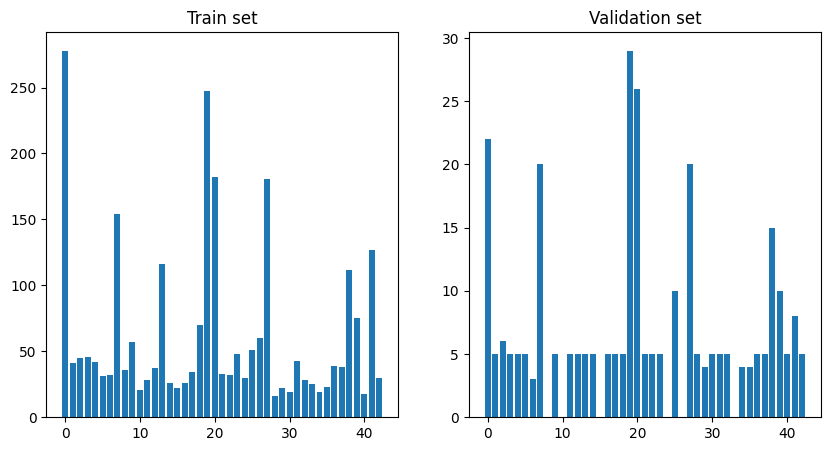

In [9]:
###Balancing data

#-Showing distribution of test and validation set
unique_train_class, counts_train_class = np.unique(train_dset.labels, return_counts=True)
unique_val_class, counts_val_class = np.unique(val_dset.labels, return_counts=True)
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.bar(unique_train_class, counts_train_class)
plt.title('Train set')
plt.subplot(1,2,2)
plt.bar(unique_val_class, counts_val_class)
plt.title('Validation set')
plt.show()

In [10]:
train_dl = DataLoader(
    train_dset,
    batch_size=cfg_hyp['batch_size'],
    shuffle=True
)

increased_train_dl = DataLoader(
    increased_dataset,
    batch_size=cfg_hyp['batch_size'],
    shuffle=True
)

balanced_train_dl = DataLoader(
    train_dset,
    sampler=train_dset.get_sampler(),
    batch_size=cfg_hyp['batch_size'],
)


val_dl = DataLoader(
    val_dset,
    batch_size=cfg_hyp['batch_size']
)
test_dl = DataLoader(
    test_dset,
    batch_size=cfg_hyp['batch_size']
)


## Utility functions

In [11]:
#For saving the result 
def create_model_directory(model_name, run, resnet=False, hyp_tune=False):
    if resnet:
        base_path = f"./resnet_results_{run}"
    else:
        if hyp_tune:
            base_path = f"./model_results_1/NetWithoutResidualBlock.cnn"
        else:
            base_path = f"./model_results_{run}"
    model_path = os.path.join(base_path, model_name)
    os.makedirs(model_path, exist_ok=True)
    return model_path

In [12]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

just a different way to compute the accuracy of the model

In [13]:
def ncorrect(scores, y):
    y_hat = torch.argmax(scores, -1)
    return (y_hat == y).sum()

def accuracy(scores, y):
    correct = ncorrect(scores, y)
    return correct.true_divide(y.shape[0])

In [35]:
import torch.optim as optim
import time
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F


def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device, model_name, model_path, stopping_patience = 10, stopping_value = 0.6, scheduler_check=False, fine_tuning=False, WANDB=False):

    model.to(device)
    best_val_acc = 0.0
    if scheduler_check:
      scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.6, patience=2, min_lr = 1e-5)

    if device == 'cuda':
      torch.cuda.empty_cache()

    num_params = count_parameters(model)

    run_stats = {
        "model_name": model_name,
        "num_parameters": num_params,
        "epochs": []
    }

    # Simple storage of train stats
    train_losses = []
    train_accs = []

    val_losses = []
    val_accs = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        start_time = time.time()

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            # loss = criterion(outputs, labels)
            loss = F.cross_entropy(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.shape[0]
            train_total += inputs.shape[0]
            train_correct += ncorrect(outputs, labels).item()

            # train_loss += loss.item() * inputs.size(0)
            # _, predicted = outputs.max(1)
            # train_total += labels.size(0)
            # train_correct += predicted.eq(labels).sum().item()

            # Storing actual values of train loss and accuracy
            train_losses.append(train_loss/train_total)
            train_accs.append(train_correct/train_total)

        train_loss = train_loss / len(train_loader.dataset)
        train_acc = train_correct / train_total

        # Validation
        val_loss, val_acc, val_tracks = evaluate_model(model, val_loader, criterion, device)

        val_losses += val_tracks[0]
        val_accs += val_tracks[1]

        if scheduler_check:
          scheduler.step(val_loss)
          last_lr = scheduler.get_last_lr()
          # last_lr = scheduler.get_last_lr()[0]
        else:
          last_lr = cfg_hyp['lr']

        epoch_time = time.time() - start_time

        epoch_stats = {
            "epoch": epoch + 1,
            "train_loss": train_loss,
            "train_acc": train_acc,
            "val_loss": val_loss,
            "val_acc": val_acc,
            "epoch_time": epoch_time
        }

        run_stats["epochs"].append(epoch_stats)

        if WANDB:
          wandb.log(epoch_stats)

        print(f"Epoch {epoch+1}/{num_epochs}, "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, "
              f"Time: {epoch_time:.2f}s, "
              f"Last learning rate: {last_lr}")

        # Save the best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            early_stopping_counter = 0
            torch.save(model.state_dict(), os.path.join(model_path, f"{model_name}_best.pth"))
            if WANDB:
              wandb.save(f"{model_name}_best.pth")

        else:
          early_stopping_counter += 1
          print(f"EarlyStoppingCounter: {early_stopping_counter} out of {stopping_patience}")

        if early_stopping_counter >= stopping_patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

        if val_acc > stopping_value:
            print(f"Stopping value reached at epoch {epoch+1}")
            break
    
    with open(os.path.join(model_path, f"{model_name}_run_stats.json"), "w") as f:
        json.dump(run_stats, f, indent=2)

    return best_val_acc, (train_losses, train_accs, val_losses, val_accs)

def evaluate_model(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    # Storing val stats for a single epoch
    val_losses_per_epoch = []
    val_accs_per_epoch = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            # loss = criterion(outputs, labels)
            loss = F.cross_entropy(outputs, labels)

            total_loss += loss.item() * inputs.shape[0]
            total += inputs.shape[0]
            correct += ncorrect(outputs, labels).item()

            # total_loss += loss.item() * inputs.size(0)
            # _, predicted = outputs.max(1)
            # total += labels.size(0)
            # correct += predicted.eq(labels).sum().item()

            # Storing actual values of train loss and accuracy
            val_losses_per_epoch.append(total_loss/total)
            val_accs_per_epoch.append(correct/total)

    avg_loss = total_loss / len(data_loader.dataset)
    accuracy = correct / total
    return avg_loss, accuracy, (val_losses_per_epoch, val_accs_per_epoch)

def train_and_evaluate(model_class, name, train_loader, val_loader, test_loader, num_classes, model_path, num_epochs=50, lr=0.001, wd=1e-5, device='cuda', stopping_patience = 10, stopping_value = 0.6, scheduler_check=False, resnet=False, fine_tuning=False, WANDB=False):

    if resnet:
      if fine_tuning:
        model = model_class(num_classes=num_classes, weights=ResNet18_Weights.IMAGENET1K_V1)
        model.load_state_dict(torch.load(os.path.join(f"resnet_results_0/{name}", f"{name}_best.pth")))
        pushed_net = model.to(device)
        ## Unfreeze all base model layer
        for layer in [pushed_net.base_model.conv1, pushed_net.base_model.bn1, pushed_net.base_model.layer1, pushed_net.base_model.layer2, pushed_net.base_model.layer3, pushed_net.base_model.layer4]:
            pushed_net.set_requires_grad(layer, train=True)
        # Updating model_name with ft (Fine Tuning)
        name = f'{name}_ft' 
      else:
        pushed_net = model_class(num_classes=num_classes, weights=ResNet18_Weights.IMAGENET1K_V1).to(device)

        ## Freeze base model layer (not fc)
        for layer in [pushed_net.base_model.conv1, pushed_net.base_model.bn1, pushed_net.base_model.layer1, pushed_net.base_model.layer2, pushed_net.base_model.layer3, pushed_net.base_model.layer4]:
            pushed_net.set_requires_grad(layer, train=False)
    else:
      model = model_class(num_classes=num_classes).to(device)
       
    
    if WANDB:
      wandb.init(project="grocery-store-classification", name=name)
      wandb.watch(pushed_net)

    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    optimizer = optim.AdamW(pushed_net.parameters(), lr=lr, weight_decay=wd)

    best_val_acc, tracks = train_model(pushed_net, train_loader, val_loader, criterion, optimizer, num_epochs, device, name, model_path, stopping_patience, stopping_value, scheduler_check, resnet, fine_tuning, WANDB)

    # Load the best model for final evaluation
    pushed_net.load_state_dict(torch.load(os.path.join(model_path, f"{name}_best.pth")))
    test_loss, test_acc, test_tracks = evaluate_model(pushed_net, test_loader, criterion, device)

    print(f"Final results for {name}:")
    print(f"Best Validation Accuracy: {best_val_acc:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")

    if WANDB:
      wandb.log({
          "best_val_acc": best_val_acc,
          "test_acc": test_acc
      })

    json_path = os.path.join(model_path, f"{name}_run_stats.json")
    with open(json_path, "r") as f:
        run_stats = json.load(f)

    run_stats["best_val_acc"] = best_val_acc
    run_stats["test_acc"] = test_acc
    
    with open(json_path, "w") as f:
        json.dump(run_stats, f, indent=2)

    if WANDB:
      wandb.finish()


    return best_val_acc, test_acc, tracks, test_tracks

## ResNet18 Model

In [15]:
from torchvision.models import resnet18, ResNet18_Weights

In [16]:
class Resnet18(torch.nn.Module):
    def __init__(self, num_classes, weights):
        super().__init__()
        self.base_model = resnet18(weights=weights)
        self.base_model.fc = torch.nn.Linear(self.base_model.fc.in_features, n_classes)
    
    def set_requires_grad(self, layer, train):
        for p in layer.parameters():
            p.requires_grad = train
    
    def forward(self, x):
        x = self.base_model(x)
        return x


## Tune hyperparameters (Freeze base model phase)

In [17]:
parameters_run = {
    'labels_runs' : ['std + scheduler'],
    'masked_train_dl': ['train_dl'],
    'masked_batch_size': [64],
    'masked_scheduler': [True]
}

For each run all parameters modified in the precedent dictionary are passed to the train function through the use of variables used as masks. 

In [18]:
models_tracks = {}
model_name = 'ResNet18'
for name in parameters_run['labels_runs']:
  models_tracks[f'{model_name}_{name}'] = {}

In [22]:
for run in range(len(parameters_run['labels_runs'])):
  masked_batch_size = parameters_run['masked_batch_size'][run]

  if parameters_run['masked_train_dl'] == 'train_dl':
    masked_train_dl = DataLoader(
      train_dset,
      batch_size=masked_batch_size,
      shuffle=True
    )
  elif parameters_run['masked_train_dl'] == 'increased_train_dl':
    masked_train_dl = DataLoader(
      increased_dataset,
      batch_size=masked_batch_size,
      shuffle=True
    )
  else:
    masked_train_dl = DataLoader(
      train_dset,
      sampler=train_dset.get_sampler(),
      batch_size=masked_batch_size,
    )
  
  val_dl = DataLoader(
      val_dset,
      batch_size=masked_batch_size
  )
  test_dl = DataLoader(
      test_dset,
      batch_size=masked_batch_size
  )

  masked_scheduler = parameters_run['masked_scheduler'][run]
  if masked_scheduler == False:
    cfg_hyp['lr'] = 3e-5
  else:
    cfg_hyp['lr'] = 3e-4
  
  model, model_name = Resnet18, f'ResNet18_{parameters_run["labels_runs"][run]}'
  if model_name not in models_tracks.keys():
    models_tracks[model_name] = {}
  
  if 'train_tracks' not in models_tracks[model_name].keys():
    model_path = create_model_directory(model_name= model_name, run=run, hyp_tune=True)
    best_val_acc, test_acc, tracks, test_tracks = train_and_evaluate(
      model_class = model,
      name = model_name,
      train_loader = masked_train_dl,
      val_loader = val_dl,
      test_loader = test_dl,
      num_classes = n_classes,
      model_path = model_path,
      num_epochs=cfg_hyp['epochs'],
      lr=cfg_hyp['lr'],
      wd=cfg_hyp['wd'],
      device=cfg_hyp['device'],
      stopping_patience = cfg_hyp['stopping_patience'],
      stopping_value = cfg_hyp['stopping_value'],
      scheduler_check=masked_scheduler,
      fine_tuning=False,
      WANDB=False
    )
    models_tracks[model_name]['model_path'] = model_path
    models_tracks[model_name]['train_tracks'] = tracks
    models_tracks[model_name]['test_tracks'] = test_tracks


/home/rda1027/miniconda3/envs/ai/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at /opt/conda/conda-bld/pytorch_1712608853085/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch 1/30, Train Loss: 3.4000, Train Acc: 0.1500, Val Loss: 3.1716, Val Acc: 0.2162, Time: 10.62s, Last learning rate: [0.0003]
Epoch 2/30, Train Loss: 2.7118, Train Acc: 0.4341, Val Loss: 2.7676, Val Acc: 0.3311, Time: 10.06s, Last learning rate: [0.0003]
Epoch 3/30, Train Loss: 2.1444, Train Acc: 0.6659, Val Loss: 2.4597, Val Acc: 0.4122, Time: 10.09s, Last learning rate: [0.0003]
Epoch 4/30, Train Loss: 1.7465, Train Acc: 0.7682, Val Loss: 2.1583, Val Acc: 0.5135, Time: 10.14s, Last learning rate: [0.0003]
Epoch 5/30, Train Loss: 1.4670, Train Acc: 0.8250, Val Loss: 1.9745, Val Acc: 0.5439, Time: 10.19s, Last learning rate: [0.0003]
Epoch 6/30, Train Loss: 1.2244, Train Acc: 0.8708, Val Loss: 1.8193, Val Acc: 0.5878, Time: 10.22s, Last learning rate: [0.0003]
Epoch 7/30, Train Loss: 1.0440, Train Acc: 0.8981, Val Loss: 1.6923, Val Acc: 0.5642, Time: 10.24s, Last learning rate: [0.0003]
EarlyStoppingCounter: 1 out of 10
Epoch 8/30, Train Loss: 0.9169, Train Acc: 0.9053, Val Loss: 1.

In [25]:
# Write new models performances in .pickle
for model_name in parameters_run['labels_runs']:
  if 'model_path' in models_tracks[f'ResNet18_{model_name}'].keys():
    pickle_path = os.path.join(models_tracks[f'ResNet18_{model_name}']['model_path'], f"{model_name}_tracks.pickle")
    with open(pickle_path, "wb") as handle:
        pickle.dump(models_tracks[f'ResNet18_{model_name}'], handle, protocol=pickle.HIGHEST_PROTOCOL)

### Plots

In [ ]:
# Reading models performances saved in .pickle
for model_name in parameters_run['labels_runs']:
  pickle_path = os.path.join(f'resnet_results_0/ResNet18_{model_name}', f"{model_name}_tracks.pickle")
  with open(pickle_path, 'rb') as handle:
    models_tracks[f'ResNet18_{model_name}'] = pickle.load(handle)

In [23]:
from matplotlib.patches import Patch
# Create legend in fig rather than an axis
def add_fig_legend(fig, n_groups, group_labels, loc='lower center', ncol=4):
    # Get colours for current style
    colours = plt.rcParams['axes.prop_cycle'].by_key()['color']
    # Set up handles (the bits that are drawn in the legend)
    handles = []
    for group_idx in range(n_groups):
        # Create a simple patch that is the correct colour
        colour = colours[group_idx]
        handles.append(Patch(edgecolor=colour, facecolor=colour, fill=True))
    # Acutally create our figure legend, using the handles and labels
    fig.legend(handles=handles, labels=group_labels, loc=loc, ncol=ncol)

Feedbacks


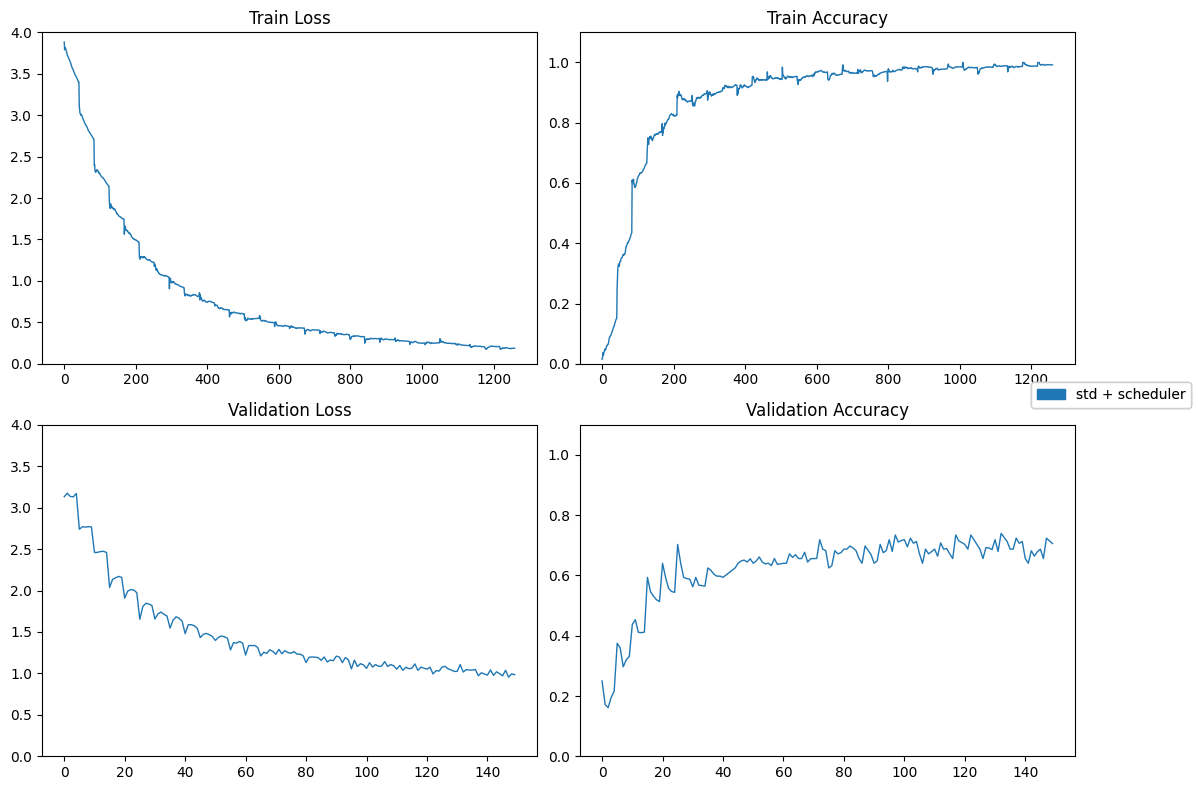

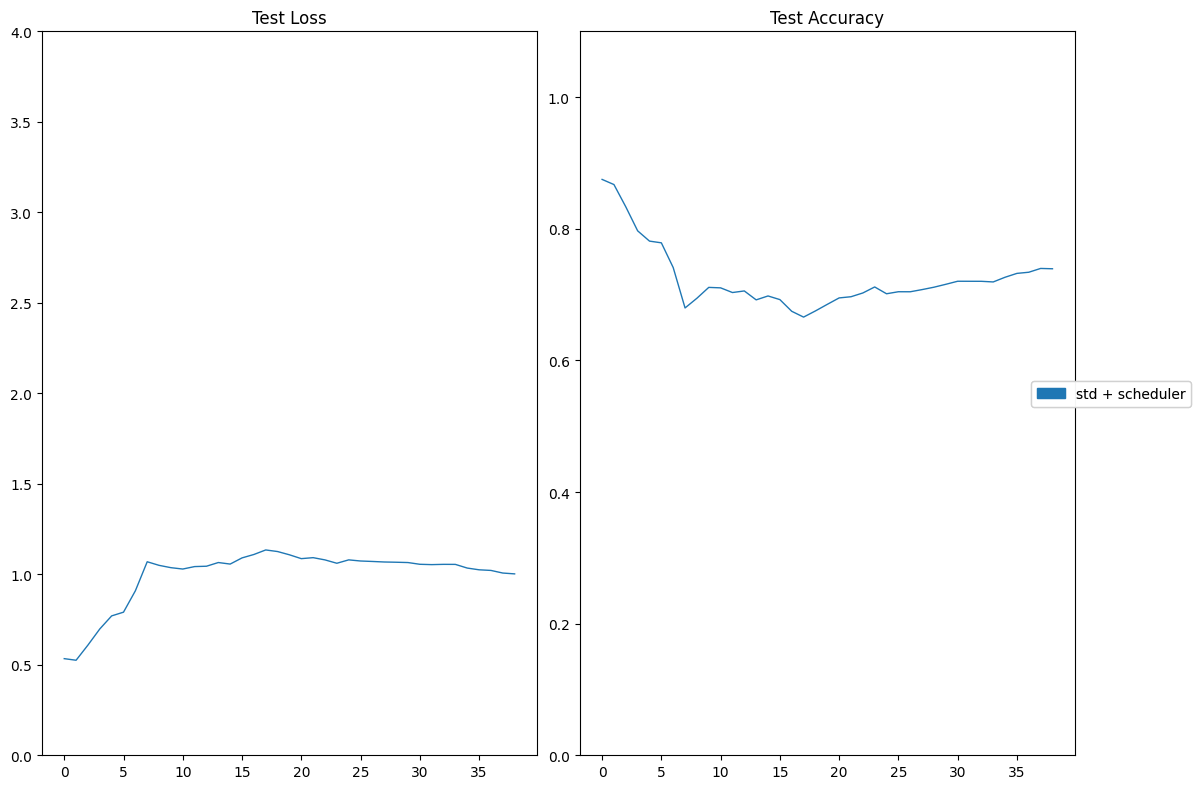

In [24]:
labels = ['Train Loss', 'Train Accuracy', 'Validation Loss', 'Validation Accuracy', 'Test Loss', 'Test Accuracy']

print(f'Feedbacks')

# Legend to right with four axes
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
for i in range(4):
    plt.subplot(2, 2, i+1)
    for model_name in parameters_run['labels_runs']:
        if 'train_tracks' in models_tracks[f'ResNet18_{model_name}'].keys():
            plt.plot(range(len(models_tracks[f'ResNet18_{model_name}']['train_tracks'][i])), models_tracks[f'ResNet18_{model_name}']['train_tracks'][i], linewidth=1, label=model_name)
    # plt.yscale('log')
    if i%2==1:
        # plt.ylim(0, max(models_tracks[model_name]['train_tracks'][i]) + 0.1)
        plt.ylim(0, 1.1)
    else:
        plt.ylim(0, 4)
    plt.title(labels[i])
    # Add the figure on the right of the plot this time
    add_fig_legend(fig, len(parameters_run['labels_runs']), parameters_run['labels_runs'], loc='center right', ncol=1)
    fig.patch.set_facecolor('white')
    plt.tight_layout()

    # Remove space from the right handside to make space for the legend
    plt.subplots_adjust(right=0.9)

plt.show()

# Legend to right with four axes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))
for i in range(4, 6):
    plt.subplot(1, 2, i-3)
    for model_name in parameters_run['labels_runs']:
        if 'test_tracks' in models_tracks[f'ResNet18_{model_name}'].keys():
            plt.plot(range(len(models_tracks[f'ResNet18_{model_name}']['test_tracks'][i-4])), models_tracks[f'ResNet18_{model_name}']['test_tracks'][i-4], linewidth=1, label=model_name)

    # plt.yscale('log')
    if i%2==1:
        # plt.ylim(0, max(models_tracks[model_name]['test_tracks'][i-4]) + 0.1)
        plt.ylim(0, 1.1)
    else:
        plt.ylim(0, 4)
    plt.title(labels[i])
    # Add the figure on the right of the plot this time
    add_fig_legend(fig, len(parameters_run['labels_runs']), parameters_run['labels_runs'], loc='center right', ncol=1)
    fig.patch.set_facecolor('white')
    plt.tight_layout()

    # Remove space from the right handside to make space for the legend
    plt.subplots_adjust(right=0.9)
plt.show()

## Fine tune hyperparameters (Unfreeze layers)

In [40]:
parameters_run = {
    'labels_runs' : ['std + scheduler'],
    'masked_train_dl': ['train_dl'],
    'masked_batch_size': [64],
    'masked_scheduler': [True]
}

In [41]:
for run in range(len(parameters_run['labels_runs'])):
  masked_batch_size = parameters_run['masked_batch_size'][run]

  if parameters_run['masked_train_dl'] == 'train_dl':
    masked_train_dl = DataLoader(
      train_dset,
      batch_size=masked_batch_size,
      shuffle=True
    )
  elif parameters_run['masked_train_dl'] == 'increased_train_dl':
    masked_train_dl = DataLoader(
      increased_dataset,
      batch_size=masked_batch_size,
      shuffle=True
    )
  else:
    masked_train_dl = DataLoader(
      train_dset,
      sampler=train_dset.get_sampler(),
      batch_size=masked_batch_size,
    )
  
  val_dl = DataLoader(
      val_dset,
      batch_size=masked_batch_size
  )
  test_dl = DataLoader(
      test_dset,
      batch_size=masked_batch_size
  )

  masked_scheduler = parameters_run['masked_scheduler'][run]
  if masked_scheduler == False:
    cfg_hyp['lr'] = 5e-6
  else:
    cfg_hyp['lr'] = 8e-6
  
  model, model_name = Resnet18, f'ResNet18_{parameters_run["labels_runs"][run]}'
  if f'{model_name}_ft' not in models_tracks.keys():
    models_tracks[f'{model_name}_ft'] = {}
  
  if 'train_tracks' not in models_tracks[f'{model_name}_ft'].keys():
    model_path = create_model_directory(model_name= f'{model_name}_ft', run=run, hyp_tune=True)
    best_val_acc, test_acc, tracks, test_tracks = train_and_evaluate(
      model_class = model,
      name = model_name,
      train_loader = masked_train_dl,
      val_loader = val_dl,
      test_loader = test_dl,
      num_classes = n_classes,
      model_path = model_path,
      num_epochs=cfg_hyp['epochs'],
      lr=cfg_hyp['lr'],
      wd=cfg_hyp['wd'],
      device=cfg_hyp['device'],
      stopping_patience = cfg_hyp['stopping_patience'],
      stopping_value = cfg_hyp['stopping_value'],
      scheduler_check=masked_scheduler,
      fine_tuning=True,
      WANDB=False
    )
    models_tracks[model_name]['model_path'] = model_path
    models_tracks[model_name]['train_tracks'] = tracks
    models_tracks[model_name]['test_tracks'] = test_tracks


Epoch 1/30, Train Loss: 0.2584, Train Acc: 0.9818, Val Loss: 1.0041, Val Acc: 0.7162, Time: 17.65s, Last learning rate: [8e-06]
Epoch 2/30, Train Loss: 0.1748, Train Acc: 0.9902, Val Loss: 0.8959, Val Acc: 0.7534, Time: 17.69s, Last learning rate: [8e-06]
Epoch 3/30, Train Loss: 0.1238, Train Acc: 0.9958, Val Loss: 0.8395, Val Acc: 0.7635, Time: 17.63s, Last learning rate: [8e-06]
Epoch 4/30, Train Loss: 0.0980, Train Acc: 0.9973, Val Loss: 0.8053, Val Acc: 0.7804, Time: 17.66s, Last learning rate: [8e-06]
Epoch 5/30, Train Loss: 0.0739, Train Acc: 0.9992, Val Loss: 0.7573, Val Acc: 0.7736, Time: 17.65s, Last learning rate: [8e-06]
EarlyStoppingCounter: 1 out of 10
Epoch 6/30, Train Loss: 0.0638, Train Acc: 0.9985, Val Loss: 0.7512, Val Acc: 0.7872, Time: 17.71s, Last learning rate: [8e-06]
Epoch 7/30, Train Loss: 0.0504, Train Acc: 0.9996, Val Loss: 0.7120, Val Acc: 0.8108, Time: 17.71s, Last learning rate: [8e-06]
Epoch 8/30, Train Loss: 0.0425, Train Acc: 0.9996, Val Loss: 0.6921, V

In [31]:
models_tracks

{'ResNet18_std + scheduler': {'model_path': './resnet_results_0/ResNet18_std + scheduler',
  'train_tracks': ([3.882380485534668,
    3.7897958755493164,
    3.8202157020568848,
    3.800514340400696,
    3.8049432754516603,
    3.783984899520874,
    3.7723149231501987,
    3.757003515958786,
    3.7320106824239097,
    3.7195836544036864,
    3.714878862554377,
    3.7047846913337708,
    3.6938710579505334,
    3.6873911448887418,
    3.6752840677897134,
    3.661114737391472,
    3.6499352595385384,
    3.6387603415383234,
    3.628940695210507,
    3.6123027086257933,
    3.5965603646777926,
    3.5821263790130615,
    3.5758694980455483,
    3.564805050690969,
    3.5563775539398192,
    3.5467522144317627,
    3.5335057046678333,
    3.523870187146323,
    3.512533656482039,
    3.5042389631271362,
    3.4934783135690997,
    3.482274480164051,
    3.474830323999578,
    3.4649741228889015,
    3.4586039883749824,
    3.449162165323893,
    3.4411242330396496,
    3.430225573087

## Access Dataloader

In [4]:
from pathlib import Path
from PIL import Image
from torch import Tensor
from torch.utils.data import Dataset
from typing import List, Tuple

In [5]:
class GroceryStoreDataset(Dataset):

    def __init__(self, split: str, transform=None) -> None:
        super().__init__()

        self.root = Path("GroceryStoreDataset/dataset")
        self.split = split
        self.paths, self.labels = self.read_file()

        self.transform = transform

    def __len__(self) -> int:
        return len(self.labels)

    def __getitem__(self, idx) -> Tuple[Tensor, int]:
        img = Image.open(self.root / self.paths[idx])
        label = self.labels[idx]

        if self.transform:
            img = self.transform(img)

        return img, label

    def read_file(self) -> Tuple[List[str], List[int]]:
        paths = []
        labels = []

        with open(self.root / f"{self.split}.txt") as f:
            for line in f:
                # path, fine-grained class, coarse-grained class
                path, _, label = line.replace("\n", "").split(", ")
                paths.append(path), labels.append(int(label))

        return paths, labels

    def get_num_classes(self) -> int:
        return max(self.labels) + 1

In [6]:
from torchvision import transforms as T, datasets

In [7]:
## Rimettere a 260x260

tsfms_std = T.Compose([
    T.Resize(size=(224, 224)),
    T.ToTensor(),
    # T.Lambda(lambda x: x.flatten()),
])

tsfms_increasing = T.Compose([
    T.RandomHorizontalFlip(),
    T.RandomResizedCrop(size=(150, 150), scale=(0.7, 0.9)),
    T.ToTensor(),
    T.Resize(size=(224, 224)),
    # T.Lambda(lambda x: x.flatten()),
])

train_dset = GroceryStoreDataset(
    split="train",
    transform=tsfms_std,
)
increased_train_dst = GroceryStoreDataset(
    split="train",
    transform=tsfms_increasing,
)
val_dset = GroceryStoreDataset(
    split="val",
    transform=tsfms_std,
)
test_dset = GroceryStoreDataset(
    split="test",
    transform=tsfms_std,
)
n_classes = 43
input_dim = len(train_dset[0][0])

increased_dataset = torch.utils.data.ConcatDataset([increased_train_dst,train_dset])
print(len(increased_dataset))

5280


In [8]:
from torch.utils.data import DataLoader

In [9]:
print(len(train_dset))
print(len(val_dset))

2640
296


In [10]:
batch_size = 64

train_dl = DataLoader(
    train_dset,
    batch_size=batch_size,
    shuffle=True
)
val_dl = DataLoader(
    val_dset,
    batch_size=batch_size
)
test_dl = DataLoader(
    test_dset,
    batch_size=batch_size
)

## ResNet Model

In [11]:
from torchvision.models import resnet18, ResNet18_Weights

In [27]:
class Resnet18(torch.nn.Module):
    def __init__(self, n_classes, weights):
        super().__init__()
        self.base_model = resnet18(weights=weights)
        self.base_model.fc = torch.nn.Linear(self.base_model.fc.in_features, n_classes)
    
    def set_requires_grad(self, layer, train):
        for p in layer.parameters():
            p.requires_grad = train
    
    def forward(self, x):
        x = self.base_model(x)
        return x


In [28]:
resnet_model = Resnet18(
    n_classes=n_classes,
    weights=ResNet18_Weights.IMAGENET1K_V1
)

In [29]:
pushed_net = resnet_model.to(device)

In [30]:
## Freeze base model layer (not fc)
for layer in [pushed_net.base_model.conv1, pushed_net.base_model.bn1, pushed_net.base_model.layer1, pushed_net.base_model.layer2, pushed_net.base_model.layer3, pushed_net.base_model.layer4]:
    pushed_net.set_requires_grad(layer, train=False)

### Compile network

In [22]:
from torch.optim import Adam, AdamW
from torch.optim.lr_scheduler import OneCycleLR, ReduceLROnPlateau

In [31]:
initial_lr = 1e-3
optimizer = AdamW(pushed_net.parameters(), lr=initial_lr, weight_decay=1e-4)
num_epochs = 30
num_steps = num_epochs * len(train_dl)
# lr_scheduler = OneCycleLR(optimizer, initial_lr, total_steps=num_steps)
lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.6, patience=2, min_lr=1e-5)

## Train network

In [24]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [32]:
def ncorrect(scores, y):
    y_hat = torch.argmax(scores, -1)
    return (y_hat == y).sum()

def accuracy(scores, y):
    correct = ncorrect(scores, y)
    return correct.true_divide(y.shape[0])

def train_loop(model, train_dl, batch_size, constant_lr, epochs, opt, scheduler, val_dl=None, verbose=False):
    best_val_acc = 0
    best_params = []
    best_epoch = -1

    train_losses = []
    train_accs = []

    val_losses = []
    val_accs = []

    for e in tqdm(range(epochs)):
    # for e in range(epochs):
        model.train()
        # Train
        train_loss = 0
        train_samples = 0
        train_acc = 0
        # running_loss = 0
        # correct = 0
        # total = 0

        ## Get last learning rate
        if scheduler != None:
            lr = scheduler.get_last_lr()
        else:
            lr = constant_lr

        for i, train_data in enumerate(train_dl):
            imgs = train_data[0].to(device)
            labels = train_data[1].to(device)

            opt.zero_grad()  # clear

            scores = model(imgs)
            loss = F.cross_entropy(scores, labels)

            loss.backward()  # fill
            opt.step()       # Weight Optimizer step
            # scheduler.step() # Learning Rate Scheduler step

            train_loss += loss.item() * imgs.shape[0]
            train_samples += imgs.shape[0]
            train_acc += ncorrect(scores, labels).item()

            train_losses.append(train_loss/train_samples)
            train_accs.append(train_acc/train_samples)

            ## Write in tensorboard
            # if i % batch_size == batch_size-1:
                # train_losses.append(train_loss/batch_size)
                # train_accs.append(train_acc/batch_size)
                # if writer != None:
                #     writer.add_scalar("Loss/train", train_loss/batch_size, e)
                #     writer.add_scalar("Accuracy/train", train_acc/batch_size, e)

            
        # train_loss = running_loss / len(train_dl)
        # train_acc = 100 * correct / total
        train_acc /= train_samples
        train_loss /= train_samples

        # Validation
        model.eval()
        with torch.no_grad():
            val_loss = 0
            val_samples = 0
            val_acc = 0
            # correct = 0
            # total = 0
            if val_dl is not None:
                for i, val_data in enumerate(val_dl):
                    imgs = val_data[0].to(device)
                    labels = val_data[1].to(device)
                    val_scores = model(imgs)
                    val_loss += F.cross_entropy(val_scores, labels).item() * imgs.shape[0]

                    val_samples += imgs.shape[0]
                    val_acc += ncorrect(val_scores, labels).item()

                    val_losses.append(val_loss/val_samples)
                    val_accs.append(val_acc/val_samples)

                    # if i % batch_size == batch_size-1:
                        # val_losses.append(val_loss/batch_size)
                        # val_accs.append(val_acc/batch_size)
                        # if writer != None:
                        #     writer.add_scalar("Loss/val", val_loss/batch_size, e)
                        #     writer.add_scalar("Accuracy/val", val_acc/batch_size, e)

                    # val_scores = model(imgs)
                    # _, predicted = torch.max(val_scores.data, 1)
                    # total += labels.size(0)
                    # correct += (predicted == labels).sum().item()

                val_acc /= val_samples
                val_loss /= val_samples
                # val_acc = 100 * correct / total

            if val_dl is None or val_acc > best_val_acc:
                best_val_acc = val_acc if val_dl is not None else 0
                best_params = model.state_dict()
                torch.save(best_params, "best_model2.pth")
                best_epoch = e
        
        #### Learning Rate Scheduler step
        ## if scheduler == ReduceLROnPlateau
        if isinstance(scheduler,ReduceLROnPlateau):
            scheduler.step(val_loss)
            # scheduler.step(val_acc)
        elif isinstance(scheduler,OneCycleLR):
            scheduler.step()

        # if verbose and e % 5 == 0:
        if verbose:
            print(f"Epoch {e}: lr {lr} - train loss {train_loss:.3f} - train acc {train_acc:.3f}" + ("" if val_dl is None else f" - valid loss {val_loss:.3f} - valid acc {val_acc:.3f}"))
            # print(f"Epoch {e}: train loss {train_loss:.3f} - train acc {train_acc:.3f}" + ("" if val_dl is None else f" - valid loss - valid acc {val_acc:.3f}"))

    if verbose and val_dl is not None:
        print(f"Best epoch {best_epoch}, best acc {best_val_acc}")

    return best_val_acc, best_params, best_epoch, (train_losses, train_accs, val_losses, val_accs)

In [33]:
best_val_acc, best_params, best_epoch, tracks = train_loop(
    pushed_net,
    train_dl,
    batch_size,
    1e-3,
    num_epochs,
    optimizer,
    lr_scheduler,
    val_dl,
    verbose=True
)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 0: lr [0.001] - train loss 2.676 - train acc 0.343 - valid loss 2.212 - valid acc 0.436
Epoch 1: lr [0.001] - train loss 1.457 - train acc 0.664 - valid loss 1.641 - valid acc 0.598
Epoch 2: lr [0.001] - train loss 0.948 - train acc 0.818 - valid loss 1.350 - valid acc 0.679
Epoch 3: lr [0.001] - train loss 0.688 - train acc 0.884 - valid loss 1.211 - valid acc 0.703
Epoch 4: lr [0.001] - train loss 0.518 - train acc 0.933 - valid loss 1.151 - valid acc 0.669
Epoch 5: lr [0.001] - train loss 0.425 - train acc 0.950 - valid loss 1.056 - valid acc 0.703
Epoch 6: lr [0.001] - train loss 0.362 - train acc 0.955 - valid loss 1.030 - valid acc 0.730
Epoch 7: lr [0.001] - train loss 0.306 - train acc 0.968 - valid loss 1.008 - valid acc 0.720
Epoch 8: lr [0.001] - train loss 0.261 - train acc 0.971 - valid loss 0.974 - valid acc 0.740
Epoch 9: lr [0.001] - train loss 0.231 - train acc 0.983 - valid loss 0.937 - valid acc 0.720
Epoch 10: lr [0.001] - train loss 0.202 - train acc 0.982 - 

In [34]:
torch.cuda.empty_cache()

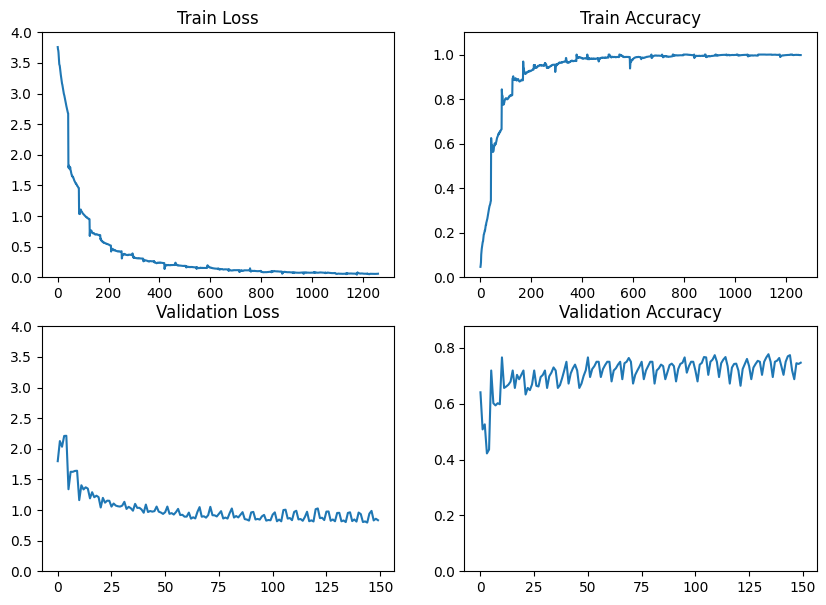

In [35]:
labels = ['Train Loss', 'Train Accuracy', 'Validation Loss', 'Validation Accuracy']

plt.figure(figsize=(10, 7))

for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.plot(range(len(tracks[i])), tracks[i])
    # plt.yscale('log')
    if i%2==1:
        plt.ylim(0, max(tracks[i]) + 0.1)
    else:
        plt.ylim(0, 4)
    plt.title(labels[i])
plt.show()

## Fine Tune ResNet18

In [36]:
## Unfreeze base model layer (not fc)
for layer in [pushed_net.base_model.conv1, pushed_net.base_model.bn1, pushed_net.base_model.layer1, pushed_net.base_model.layer2, pushed_net.base_model.layer3, pushed_net.base_model.layer4]:
    pushed_net.set_requires_grad(layer, train=True)

In [37]:
initial_lr = 1e-5
optimizer = AdamW(pushed_net.parameters(), lr=initial_lr, weight_decay=1e-5)
num_epochs = 30
num_steps = num_epochs * len(train_dl)
# lr_scheduler = OneCycleLR(optimizer, initial_lr, total_steps=num_steps)
lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.6, patience=2, min_lr=1e-6)

In [38]:
best_val_acc, best_params, best_epoch, fine_tune_tracks = train_loop(
    pushed_net,
    train_dl,
    batch_size,
    1e-6,
    num_epochs,
    optimizer,
    lr_scheduler,
    val_dl,
    verbose=True
)

  0%|          | 0/30 [00:00<?, ?it/s]

/home/rda1027/miniconda3/envs/ai/lib/python3.11/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at /opt/conda/conda-bld/pytorch_1712608853085/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 0: lr [1e-05] - train loss 0.042 - train acc 0.999 - valid loss 0.781 - valid acc 0.784
Epoch 1: lr [1e-05] - train loss 0.019 - train acc 1.000 - valid loss 0.735 - valid acc 0.791
Epoch 2: lr [1e-05] - train loss 0.013 - train acc 1.000 - valid loss 0.740 - valid acc 0.797
Epoch 3: lr [1e-05] - train loss 0.009 - train acc 1.000 - valid loss 0.702 - valid acc 0.807
Epoch 4: lr [1e-05] - train loss 0.008 - train acc 1.000 - valid loss 0.701 - valid acc 0.804
Epoch 5: lr [1e-05] - train loss 0.006 - train acc 1.000 - valid loss 0.675 - valid acc 0.807
Epoch 6: lr [1e-05] - train loss 0.006 - train acc 1.000 - valid loss 0.663 - valid acc 0.814
Epoch 7: lr [1e-05] - train loss 0.004 - train acc 1.000 - valid loss 0.654 - valid acc 0.818
Epoch 8: lr [1e-05] - train loss 0.004 - train acc 1.000 - valid loss 0.642 - valid acc 0.821
Epoch 9: lr [1e-05] - train loss 0.003 - train acc 1.000 - valid loss 0.646 - valid acc 0.811
Epoch 10: lr [1e-05] - train loss 0.003 - train acc 1.000 - 

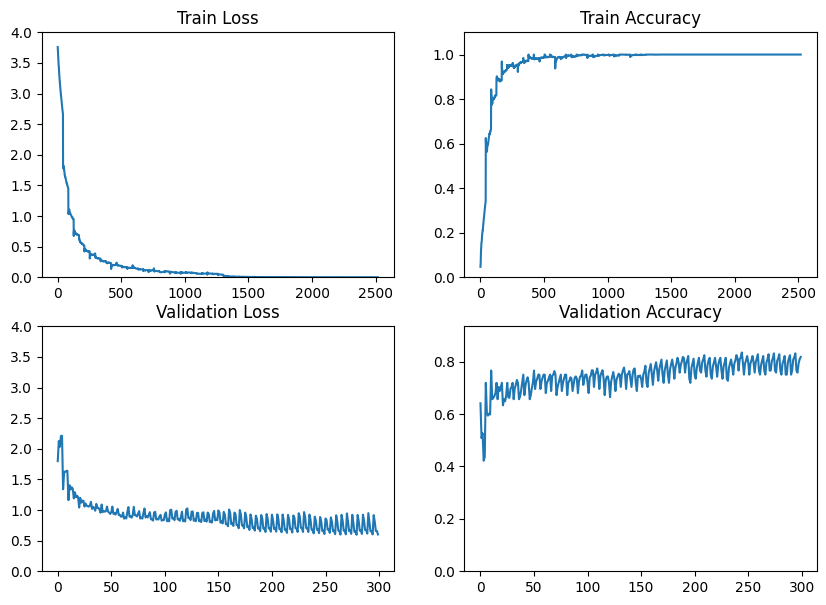

In [41]:
labels = ['Train Loss', 'Train Accuracy', 'Validation Loss', 'Validation Accuracy']

plt.figure(figsize=(10, 7))

for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.plot(range(len(tracks[i]) + len(fine_tune_tracks[i])), tracks[i] + fine_tune_tracks[i])
    # plt.yscale('log')
    if i%2==1:
        plt.ylim(0, max(fine_tune_tracks[i]) + 0.1)
    else:
        plt.ylim(0, 4)
    plt.title(labels[i])
plt.show()